In [32]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from utils import get_distance_matrix, get_average_compression, sample_spherical, compression_grouping
from matplotlib import pyplot as plt
from plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
# Number of clusters (excl. outliers)
k = 4

# Points per cluster (excl. outliers)
n = [500] * k

# Number of dimensions
d = 100

# Number of outliers
o = 10

# Cluster sizes
cluster_sizes = n + [o]

# Total clusters
k_total = k + (1 if o > 0 else 0)

In [194]:
"""
Generate cluster centers for non-outliers: 
1. Fixed clusters at (0, 0, ..., 0), (0.5, 0.5, ..., 0.5), and (1, 1, ..., 1) with some alpha
2. Different spheres with some radius 
"""

# 1:
alpha = 5
# delta = 0.5
# x = alpha * np.zeros((1, d))

# while x.shape[0] < k: 
#     x = np.vstack((x, alpha * (np.zeros((1, d)) + delta)))
#     delta += 0.5

zero = np.zeros((1, d))
x = np.empty((0, d))
# C1 = first half 0, second half 1
half = np.zeros((1, ((3 * d) // 5))) + 0.1
half2 = np.zeros((1, d - ((3 * d) // 5))) + 1.1
x = np.vstack((x, np.hstack((half, half2))))
# C2 = first half 0.25, second half 0.75
half = np.zeros((1, d // 2)) + 0.25
half2 = np.zeros((1, d // 2)) + 0.75
x = np.vstack((x, np.hstack((half, half2))))
# C3 = first half 1, second half 0
half = np.zeros((1, d // 2)) + 1
half2 = np.zeros((1, d // 2))
x = np.vstack((x, np.hstack((half, half2))))
# C4 = 
one = np.zeros((1, d//3)) + 0.8 
two = np.zeros((1, d//3)) + 0.2
three = np.zeros((1, (d - 2*(d//3)))) + 0.6
x = np.vstack((x, np.hstack((one, two, three))))

x = x * alpha

# Introduce some ranodom values to ensure Rank(x) = k
# x = x + np.random.normal(0, 0.001, (k, d))

# 2: 
# r_min = 10 
# r_max = 50
# x = np.empty((0, d))
# for i in range(k): 
#     x = np.vstack((x, sample_spherical(1, d, r_min, r_max)))

assert x.shape == (k, d)

In [195]:
np.linalg.matrix_rank(x)

4

In [196]:
D_centers = get_distance_matrix(x)
D_centers

array([[ 0.        , 16.00781059, 47.16990566, 27.29468813],
       [16.00781059,  0.        , 37.5       , 19.7673974 ],
       [47.16990566, 37.5       ,  0.        , 25.03996805],
       [27.29468813, 19.7673974 , 25.03996805,  0.        ]])

In [300]:
"""
Generate non-outlier data points: 
1. Bernoulli noise with some p 
2. Gaussian noise with some variance
"""

# 1: 
p = 0.3
Y = np.zeros((0, d))
noise_arr = []
for i in range(k): 
    noise_idx = np.random.randint(0, n[i])
    for j in range(n[i]):    
        m = np.random.uniform(2, 6)
        noise = np.random.choice([m, 0, -m], size=(1, d), p=[(1-p)/2., p, (1-p)/2.])
        point = x[i] + noise
        if j == noise_idx: 
            noise_arr.append(noise)
        Y = np.vstack((Y, point))

# 2:
# sigma = 5
# Y = np.zeros((0, d))
# for i in range(k): 
#     for j in range(n[i]): 
#         point = x[i] + np.random.normal(0, sigma, size=(1, d))
#         Y = np.vstack((Y, point))

assert Y.shape == (sum(n), d)

In [301]:
"""
Generate outliers: 
1. Sample on different unit spheres with some random radius
2. Average sample of one point from each cluster
3. Randomly select two clusters and take a weighted average of one point from each
"""

# 1: 
# r_min = 30
# r_max = 50

# for i in range(o): 
#     outlier = sample_spherical(1, d, r_min, r_max)
#     Y = np.vstack((Y, outlier))

# 2: 
# for i in range(o): 
#     sample = []

#     # Generate alpha values, summing to 1: 
#     a = np.random.dirichlet(np.ones(k), size=1)[0]
#     for i in range(len(cluster_sizes) - 1): 
#         point_idx = np.random.randint(sum(cluster_sizes[:i]), sum(cluster_sizes[:i+1]))
#         # point = Y[point_idx] + np.random.choice([5, 0, -5], size=(1, d), p=[(1-p)/2., p, (1-p)/2.])
#         sample.append(Y[point_idx])
#     point = [sample[j] * a[j] for j in range(len(sample))]
#     Y = np.vstack((Y, sum(point)))

# 3: 
for i in range(o): 
    clusters = np.random.choice(range(len(cluster_sizes) - 1), size=2, replace=False)
    weight = np.random.uniform(0.4, 0.6)
    sample = [
        Y[np.random.randint(sum(cluster_sizes[:clusters[0]]), sum(cluster_sizes[:clusters[0]+1]))],
        Y[np.random.randint(sum(cluster_sizes[:clusters[1]]), sum(cluster_sizes[:clusters[1]+1]))]
    ]
    point = (sample[0] * weight) + (sample[1] * (1 - weight))
    Y = np.vstack((Y, point))


assert Y.shape == (sum(cluster_sizes), d)

In [302]:
"""
Compute distance matrix
"""

D_pre = get_distance_matrix(Y)

In [303]:
"""
Compare intra and inter cluster distances
"""

avg_intercluster_distance, avg_intracluster_distance = get_average_compression(D_pre, cluster_sizes, k_total)

avg_intercluster_distance, avg_intracluster_distance

(array([58.45242617, 55.13783349, 61.27472679, 54.13347023, 47.51816457]),
 array([49.07085066, 48.818958  , 48.25917085, 47.96251189, 38.97013424]))

In [304]:
"""
Compare norms of outliers with sample of cluster points
"""
l2 = []
for i in range(len(cluster_sizes) - 1): 
    point_idx = np.random.randint(sum(cluster_sizes[:i]), sum(cluster_sizes[:i+1]))
    l2.append(np.linalg.norm(Y[point_idx]))

print("Non-outliers:")
print(l2)

l2_outliers = []
for i in range(o): 
    idx = -1 * (i + 1)
    dist = round(np.linalg.norm(Y[idx]), 3)
    l2_outliers.append(dist)

print("Outliers:")
print(l2_outliers)

Non-outliers:
[38.123599132228335, 43.3102698798803, 38.78060499747476, 53.0766889634479]
Outliers:
[36.161, 39.009, 31.436, 42.338, 32.25, 35.147, 48.032, 35.006, 35.566, 35.791]


In [305]:
"""
Compute PCA
"""
components = 3
pca = PCA(n_components=components)
pca.fit(Y)
Y_pca = pca.transform(Y)


assert Y_pca.shape == (sum(cluster_sizes), components)

In [306]:
pca.explained_variance_

array([322.58135559,  38.80937948,  31.6753456 ])

In [307]:
c2 = 10
pca2 = PCA(n_components=c2)
pca2.fit(Y)
pca2.explained_variance_

array([322.58135558,  38.79590264,  31.64920411,  17.95467441,
        17.84695268,  17.63282433,  17.06508761,  17.03962241,
        16.64980968,  16.2810009 ])

In [308]:
"""
Compute post PCA distances and compression matrix
"""
D_post = get_distance_matrix(Y_pca)
C = D_pre / D_post

/var/folders/p0/nb5t36rs6p5_2b9yzyw6y8hw0000gn/T/ipykernel_1580/2171040057.py:5: RuntimeWarning:

invalid value encountered in divide



In [309]:
"""
Compute average inter and intra cluster compression
"""
avg_intercluster_compression, avg_intracluster_compression = get_average_compression(C, cluster_sizes, k_total)
avg_intercluster_compression, avg_intracluster_compression

(array([2.18628744, 2.44772007, 1.73429363, 2.26882707, 2.77832412]),
 array([7.69486272, 7.52462297, 7.51355091, 7.77213822, 3.19059763]))

In [310]:
cgraph = compression_grouping(C, cluster_sizes)

In [311]:
cgraph = cgraph[::-1]

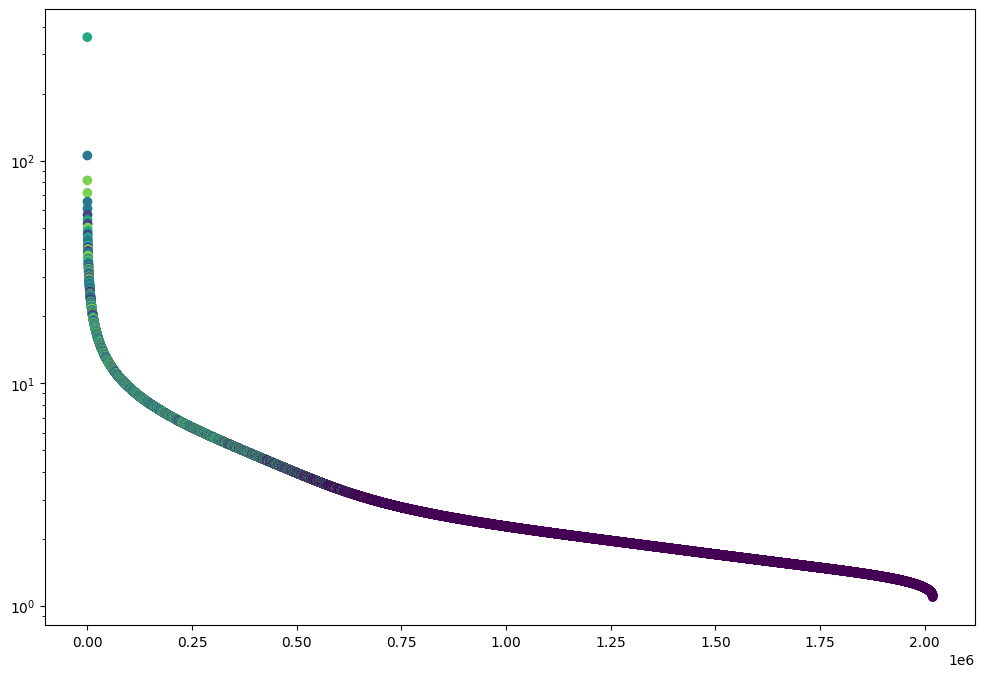

In [312]:
step_size = 100
index = list(range(0, len(cgraph), step_size))

plt.figure(figsize=(12,8))
# Plot values from test colored if inter or intra cluster, x axis is index
plt.scatter(index, cgraph[index, 0], c=cgraph[index, 1])
# Set vertical scale to be logarithmic
plt.yscale('log')
plt.show()

In [313]:
curr = 0
prop = []
for i in range(len(cgraph)): 
    if cgraph[i, 1] != 0: 
        curr += 1
    prop.append(curr / (i + 1))

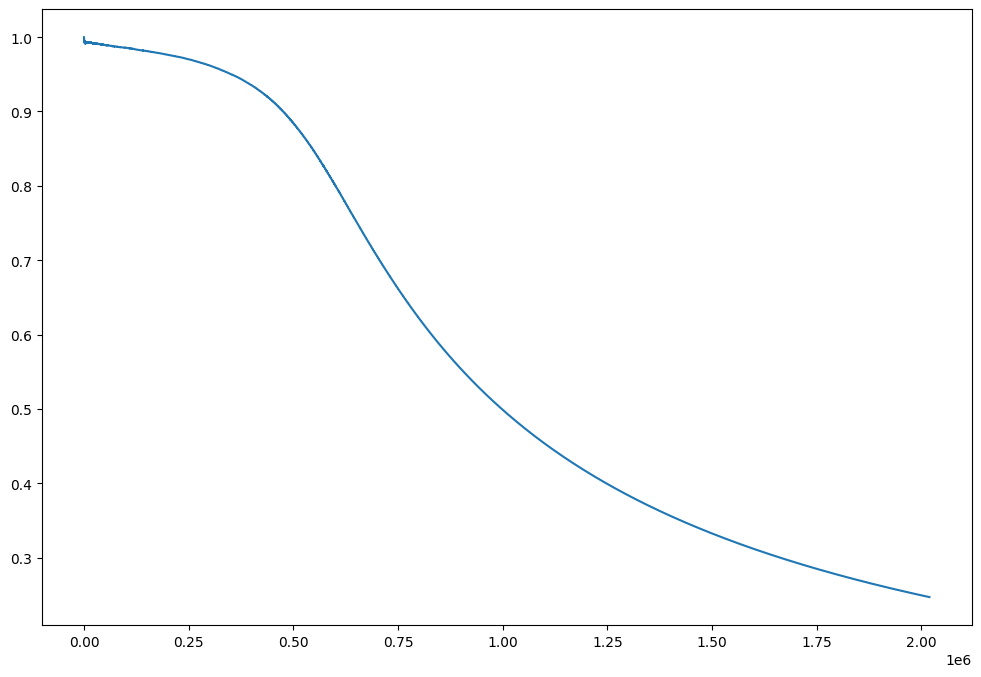

In [319]:
plt.figure(figsize=(12,8))
# Plot values from test colored if inter or intra cluster, x axis is index
plt.plot(range(len(prop)), prop)
# Set vertical scale to be logarithmic
# plt.yscale('log')
plt.show()

In [315]:
noise_norm = [np.linalg.norm(noise_arr[i]) for i in range(len(noise_arr))]

In [316]:
noise_norm

[47.29341861445219, 35.859285763476706, 47.62040131400408, 26.33376486383604]

In [46]:
norms = []
for i in range(len(cluster_sizes) - 1): 
    point_idx = np.random.randint(sum(cluster_sizes[:i]), sum(cluster_sizes[:i+1]))
    norms.append(np.linalg.norm(Y[point_idx]))

norms

[0.2654650386620251,
 49.94846657151208,
 99.986403017561,
 150.01338666262598,
 199.97891653110605,
 249.9963414101816]

In [16]:
cgraph[:, 0]

array([ 1.00000062,  1.00000064,  1.00000065, ..., 22.6477368 ,
       30.42800982, 31.31410374])

In [17]:
range(len(cgraph))

range(0, 180300)

In [ ]:
showPlot(list(range(len(cgraph))), cgraph[:, 0], "Compressibility", cgraph[:, 1])

In [40]:
# Add outliers to real datasets, similar approach
# Ex. For each outliers choose 2 clusters randomly and mix them with some alpha (alpha 0.4-0.6)

In [14]:
def cgraph(X, dim):
    """
    Calculate PCA compressibility of all pairs of X
    """
    pca = PCA(n_components=dim)
    pca.fit(X)
    X_pca = pca.transform(X)
    D_pre = get_distance_matrix(X)
    D_post = get_distance_matrix(X_pca)
    C = D_pre / D_post

    # Make n^2 x 2 matrix of all pairs of points with 0 if intercluster and 1 if intracluster
    size = (len(C) * (len(C) - 1)) / 2
    res = np.zeros((int(size), 2))
    next = 0
    for i in range(len(C)): 
        for j in range(i + 1, len(C)): 

            # Check if i and j are in the same cluster
            if i // 1000 == j // 1000: 
                print(i, j)

            res[next] = [C[i][j], 0 if i // 1000 == j // 1000 else 1]
            next += 1
    
    return res